In [4]:
#  %pip install patchify


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler


Segmentation Models: using `keras` framework.


In [2]:
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing



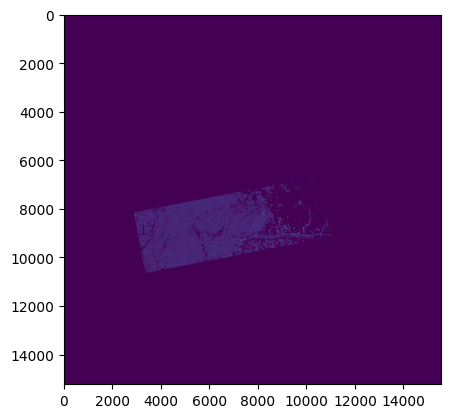

In [4]:
from keras.utils import to_categorical
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

img = cv2.imread("data/images/20190225_044811_0f2b_3B_AnalyticMS_SR_forestmask_clipped.tif")
plt.imshow(img[:,:,2])
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
image = preprocess_input(input_img)

# original_mask = cv2.imread("data/masks/812_mask.tif")
# original_mask = original_mask[:,:,0]  #Use only single channel...

# # # original_mask = to_categorical(original_mask, num_classes=2)

In [5]:
# import cv2
# import numpy as np

# # Load the TIFF image
# image_path = 'data/images/813.tif'
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# # Perform Histogram Equalization
# equalized_image = cv2.equalizeHist(image)

# # Save or display the equalized image
# cv2.imwrite('data/images/813_equal.tif', equalized_image)
# # Or display the image usingv matplotlib or other libraries


In [6]:
# import cv2
# import numpy as np

# # Load the TIFF image

# image = cv2.imread(image_path)

# # Convert to RGB format
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Split channels
# r, g, b = cv2.split(image_rgb)

# # Perform Histogram Equalization on each channel
# r_equalized = cv2.equalizeHist(r)
# g_equalized = cv2.equalizeHist(g)
# b_equalized = cv2.equalizeHist(b)

# # Merge the equalized channels back into an RGB image
# equalized_image = cv2.merge((r_equalized, g_equalized, b_equalized))

# # Save or display the equalized RGB image
# cv2.imwrite('data/images/813_equalColor.tif', cv2.cvtColor(equalized_image, cv2.COLOR_RGB2BGR))
# # Or display the image using matplotlib or other libraries


In [4]:
# import numpy as np

# # Assuming input_img is a NumPy array
# input_img = input_img.astype(np.float32)

# # Now, input_img has been converted to float32 data type.
image.shape

(3979, 8139, 3)

In [5]:
from keras.models import load_model
model = load_model("Unetcustom_TotalLoss_SoftmaxAdam250LRschedule2000Decay1e4.hdf5", compile=False)

In [6]:
# #UnetDropout_TotalLoss_SoftmaxAdam250LRscheduleDecay1e4
# Unetcustom_TotalLoss_SoftmaxAdam250LRschedule2000Decay1e4
# # UnetDropout_CE_SoftmaxAdam250LRscheduleDecay3e4


from keras.models import load_model
model = load_model("Unetpp_CE500.hdf5", compile=False)

In [6]:
seed=24
batch_size= 16
n_classes=2
patch_size=256

In [8]:
# import tensorflow as tf

# # Your code here to build the model and load data

# # Get the CPU and GPU devices
# cpu_device = tf.device('/CPU:0')
# gpu_device = tf.device('/GPU:0')
# input_data_gpu = tf.identity(input_img)

# # # Use the devices to copy tensors between CPU and GPU
# # with cpu_device:
# #     input_data_cpu = tf.constant(input_img, dtype=tf.float32)
# # with gpu_device:
# #     input_data_gpu = tf.identity(input_img)


In [9]:
# # Define your custom prediction function
# def custom_predict(img_batch_subdiv, model):
#     # Perform any preprocessing on the image batch if needed
#     # For example, you can normalize the batch to values between 0 and 1
# #     preprocessed_batch = img_batch_subdiv / 255.0

#     # Make the prediction using the model
#     predictions = model.predict(img_batch_subdiv)

#     return predictions


In [10]:

# # Call predict_img_with_smooth_windowing with your custom prediction function
# predictions_smooth = predict_img_with_smooth_windowing(
#     image,
#     window_size=patch_size,
#     subdivisions=2,
#     nb_classes=n_classes,
#     pred_func=lambda img_batch_subdiv:custom_predict(img_batch_subdiv, model)  # Use your custom prediction function
# )


In [7]:
import numpy as np

# Define the function to predict a single patch
def predict_patch(input_patch, model):
    # Pad or crop the input_patch to size (256, 256, 3)
    target_shape = (256, 256, 3)
    input_shape = input_patch.shape
    pad_height = max(target_shape[0] - input_shape[0], 0)
    pad_width = max(target_shape[1] - input_shape[1], 0)
    input_patch = np.pad(input_patch, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0.0)
    input_patch = input_patch[:target_shape[0], :target_shape[1], :]

    # Add a batch dimension to the input_patch
    print(input_patch.shape)
    input_patch = np.expand_dims(input_patch, axis=0)
    # Convert the input_patch to dtype float32
    input_patch = input_patch.astype(np.float32)
    print(input_patch.dtype)
    #predict on the patch
    prediction = model.predict(input_patch)
    return prediction

# def predict_patch(input_patch, model):
#     # Pad or crop the input_patch to size (256, 256, 3)
#     target_shape = (256, 256, 3)
#     input_shape = input_patch.shape
#     pad_height = max(target_shape[0] - input_shape[0], 0)
#     pad_width = max(target_shape[1] - input_shape[1], 0)

#     # Create a new array filled with white pixels (255)
#     padded_patch = np.ones(target_shape, dtype=np.uint8) * 255

#     # Calculate the regions to be covered by the original input_patch
#     patch_end_height = min(target_shape[0], input_shape[0])
#     patch_end_width = min(target_shape[1], input_shape[1])

#     # Fill the corresponding region with the values from the input_patch
#     padded_patch[:patch_end_height, :patch_end_width, :] = input_patch[:patch_end_height, :patch_end_width, :]

#     # Add a batch dimension to the padded_patch
#     padded_patch = np.expand_dims(padded_patch, axis=0)
#     # Convert the padded_patch to dtype float32
#     padded_patch = padded_patch.astype(np.float32)

#     # Predict on the padded_patch
#     prediction = model.predict(padded_patch)
#     return prediction


# Define the function to make predictions for the entire image using smooth windowing
def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, model):
    img_height, img_width, _ = input_img.shape

    # Initialize the prediction result
    predictions_smooth = np.zeros((img_height, img_width, nb_classes), dtype=np.float64)

    # Iterate over each patch using the given window_size
    for x in range(0, img_width, window_size // subdivisions):
        for y in range(0, img_height, window_size // subdivisions):
            x_end = min(x + window_size, img_width)
            y_end = min(y + window_size, img_height)

            # Extract the current patch from the input image
            input_patch = input_img[y:y_end, x:x_end]

            # Predict the patch using the model
            prediction_patch = predict_patch(input_patch, model)

            # Update the corresponding region in the predictions_smooth array
            predictions_smooth[y:y_end, x:x_end] = prediction_patch[0, :y_end - y, :x_end - x]

    return predictions_smooth


In [8]:
input_img =input_img
window_size = 256
subdivisions = 2
nb_classes =2
your_model =model

In [9]:
predictions_smooth = predict_img_with_smooth_windowing(img, window_size, subdivisions, nb_classes, your_model)


(256, 256, 3)
float32
1/1 [==============================] - 5s 5s/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [=============

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 8ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 8ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 6ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 6ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s

1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 8ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [===========================

(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [===========

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [=========================

(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [============

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 8ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 8ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0

1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [=========================

(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [===========

1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 

float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [=========================

(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [===========

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 9ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==========================

(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [===========

1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 11ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 12ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 10ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 13ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 15ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 14ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 20ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 24ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 22ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)
float32
1/1 [==============================] -

In [10]:
final_prediction = np.argmax(predictions_smooth, axis=2)

final_prediction.shape

(15225, 15533)

(-0.5, 15532.5, 15224.5, -0.5)

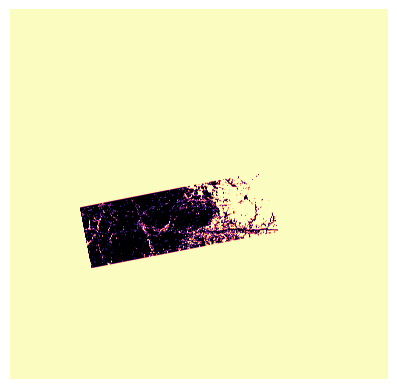

In [11]:
plt.imshow(final_prediction, cmap='magma')
plt.axis('off')
# plt.savefig('data/res/_seg.jpg', bbox_inches='tight', pad_inches=0) 


In [12]:
import matplotlib.pyplot as plt
import imageio
imageio.imsave('data/res/New_Unetcustom_TotalLoss_SoftmaxAdam250LRschedule2000Decay1e4_Seg.tif', final_prediction)
# temp_img = cv2.imread("data/images/812.tif", cv2.IMREAD_UNCHANGED)
# imageio.imsave('data/res/812.tif', temp_img[:, :, [2,1,0]]) 


### Refining result

In [ ]:
import cv2
import numpy as np

# Load the TIFF image
image_path = 'data/images/812.tif'
image = cv2.imread(image_path)

# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split channels
r, g, b = cv2.split(image_rgb)

# Perform Histogram Equalization on each channel
r_equalized = cv2.equalizeHist(r)
g_equalized = cv2.equalizeHist(g)
b_equalized = cv2.equalizeHist(b)

# Merge the equalized channels back into an RGB image
equalized_image = cv2.merge((r_equalized, g_equalized, b_equalized))

# Perform noise removal (e.g., Gaussian blur or median blur)
denoised_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
# Or use median blur: denoised_image = cv2.medianBlur(equalized_image, 5)

# Save or display the denoised RGB image
cv2.imwrite('data/images/812_deionized.tif', cv2.cvtColor(denoised_image, cv2.COLOR_RGB2BGR))
# Or display the image using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the TIFF image
image_path = 'data/images/812.tif'
image = cv2.imread(image_path)

# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split channels
r, g, b = cv2.split(image_rgb)

# Perform Histogram Equalization on each channel
r_equalized = cv2.equalizeHist(r)
g_equalized = cv2.equalizeHist(g)
b_equalized = cv2.equalizeHist(b)

# Merge the equalized channels back into an RGB image
equalized_image = cv2.merge((r_equalized, g_equalized, b_equalized))

# Perform noise removal (e.g., Gaussian blur or median blur)
denoised_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

# Convert the denoised image to grayscale
gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

# Threshold the grayscale image to create a mask for dark pixels
_, mask = cv2.threshold(gray_image, 30, 255, cv2.THRESH_BINARY_INV)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the denoised image
contour_image = denoised_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green color, thickness 2

# Save or display the contour image
cv2.imwrite('data/images/812_feature.tif', cv2.cvtColor(contour_image, cv2.COLOR_RGB2BGR))
# Or display the image using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the TIFF image
image_path = 'data/images/812.tif'
image = cv2.imread(image_path)

# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split channels
r, g, b = cv2.split(image_rgb)

# Perform Histogram Equalization on each channel
r_equalized = cv2.equalizeHist(r)
g_equalized = cv2.equalizeHist(g)
b_equalized = cv2.equalizeHist(b)

# Merge the equalized channels back into an RGB image
equalized_image = cv2.merge((r_equalized, g_equalized, b_equalized))

# Perform noise removal (e.g., Gaussian blur or median blur)
denoised_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

# Convert the denoised image to grayscale
gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

# Threshold the grayscale image to create a mask for black pixels
_, mask = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the denoised image
contour_image = denoised_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green color, thickness 2

# Save or display the contour image
cv2.imwrite('data/images/812_feature.tif', cv2.cvtColor(contour_image, cv2.COLOR_RGB2BGR))
# Or display the image using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the TIFF image
image_path = 'data/images/812.tif'
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Perform Histogram Equalization
equalized_image = cv2.equalizeHist(gray_image)

# Perform adaptive thresholding to capture dark regions
adaptive_threshold = cv2.adaptiveThreshold(equalized_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Save the thresholded image
cv2.imwrite('data/images/812_feature.tif', adaptive_threshold)
# Or display the image using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the TIFF image
image_path = 'data/images/812.tif'
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Perform Histogram Equalization
equalized_image = cv2.equalizeHist(gray_image)

# Perform adaptive thresholding to capture dark regions
adaptive_threshold = cv2.adaptiveThreshold(equalized_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Save the thresholded image
cv2.imwrite('data/images/812_feature.tif', adaptive_threshold)
# Or display the image using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the thresholded image
thresholded_image = cv2.imread('data/images/812_feature.tif', cv2.IMREAD_GRAYSCALE)

# Find contours in the thresholded image
contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
contours_image = image.copy()
cv2.drawContours(contours_image, contours, -1, (0, 255, 0), 2)  # Green color, thickness 2

# Save or display the image with detected contours
cv2.imwrite('data/images/812_features_with_contours.tif', contours_image)
# Or display the image using matplotlib or other libraries


In [ ]:
import cv2

# Load the adaptive thresholded image
adaptive_thresholded_image = cv2.imread('data/images/812_feature.tif', cv2.IMREAD_GRAYSCALE)

# Invert the adaptive thresholded image to create the binary mask
binary_mask = cv2.bitwise_not(adaptive_thresholded_image)

# Save or display the binary mask
cv2.imwrite('data/images/812_binary_mask.tif', binary_mask)
# Or display the mask using matplotlib or other libraries


In [ ]:
import cv2
image_path = 'data/images/813.tif'
image = cv2.imread(image_path)
# Load the mask
mask = cv2.imread('data/masks/813_mask.tif', cv2.IMREAD_GRAYSCALE)

# Ensure the mask and image have the same dimensions
if mask.shape[:2] != image.shape[:2]:
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# Convert the mask to binary (black and white)
_, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

# Save or display the binary mask
cv2.imwrite('data/images/813_binary_mask.tif', binary_mask)
# Or display the binary mask using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the original mask
mask = cv2.imread('data/masks/812_mask.tif', cv2.IMREAD_GRAYSCALE)

# Ensure the mask and image have the same dimensions
if mask.shape[:2] != image.shape[:2]:
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# Perform morphological operations (erosion and dilation) to improve the mask
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)
mask = cv2.dilate(mask, kernel, iterations=1)

# Convert the mask to binary (black and white)
_, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

# Save or display the improved binary mask
cv2.imwrite('data/images/812_improved_binary_mask.tif', binary_mask)
# Or display the improved binary mask using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the original mask
mask = cv2.imread('data/masks/812_mask.tif', cv2.IMREAD_GRAYSCALE)

# Ensure the mask and image have the same dimensions
if mask.shape[:2] != image.shape[:2]:
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# Perform morphological operations (erosion and dilation) to improve the mask
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)
mask = cv2.dilate(mask, kernel, iterations=1)

# Apply Canny edge detection to the mask
edges = cv2.Canny(mask, 30, 100)

# Convert the edges to binary (black and white)
binary_edges = cv2.threshold(edges, 128, 255, cv2.THRESH_BINARY)[1]

# Save or display the improved binary edges
cv2.imwrite('data/images/812_improved_binary_edges.tif', binary_edges)
# Or display the improved binary edges using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the original mask
mask = cv2.imread('data/masks/812_mask.tif', cv2.IMREAD_GRAYSCALE)

# Ensure the mask and image have the same dimensions
if mask.shape[:2] != image.shape[:2]:
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# Perform morphological operations (erosion and dilation) to improve the mask
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)
mask = cv2.dilate(mask, kernel, iterations=1)

# Apply Canny edge detection to the mask
edges = cv2.Canny(mask, 30, 100)

# Find contours in the edges image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw filled contours
filled_contours = np.zeros_like(mask)

# Fill all contours with white
cv2.drawContours(filled_contours, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Save or display the filled contours
cv2.imwrite('data/images/812_filled_contours_all.tif', filled_contours)
# Or display the filled contours using matplotlib or other libraries


In [ ]:
import cv2
import numpy as np

# Load the original mask and the input mask
original_mask = cv2.imread('data/masks/812_mask.tif', cv2.IMREAD_GRAYSCALE)
input_mask = cv2.imread('data/masks/813_UnetppLSTMDropout_BCE_SigmoidAdam50LRschedule2000Decay1e4_Seg.tif', cv2.IMREAD_GRAYSCALE)

# Check if masks are loaded correctly
if original_mask is None or input_mask is None:
    print("Error: Unable to load one or both masks.")
else:
    # Ensure the masks have the same dimensions
    if original_mask.shape[:2] != input_mask.shape[:2]:
        original_mask = cv2.resize(original_mask, (input_mask.shape[1], input_mask.shape[0]))

    # Threshold both masks to binary (black and white)
    _, original_binary = cv2.threshold(original_mask, 128, 255, cv2.THRESH_BINARY)
    _, input_binary = cv2.threshold(input_mask, 128, 255, cv2.THRESH_BINARY)

    # Perform element-wise AND operation on the masks to combine them
    output_mask = cv2.bitwise_and(original_binary, input_binary)

    # Save or display the output mask
    cv2.imwrite('data/images/812_output_mask.tif', output_mask)
    # Or display the output mask using matplotlib or other libraries
